In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from read_json import read_json  # for json files
import numpy as np
from plots import plot_histogram
from datetime import datetime
from scipy.fftpack import fft
import seaborn as sb
from numpy.linalg import norm



In [2]:
servers = ['DEVELOP','QASERVER','PRODUCCION', 'PREPRODUCCION','PRUEBAS']
def correlation(name):
    data = pd.read_csv("resampled/" + name + "_resampled.csv")
    data = data.drop(["swap_norm","bytes_total","out_bytes","in_bytes","actual_used_bytes","free","actual_used_pct","swap_free","swap_total"],axis=1)
    hm = sb.heatmap(data.loc[:, data.columns != 'cores'].corr(), cmap="Blues", annot=True).set(title=name)

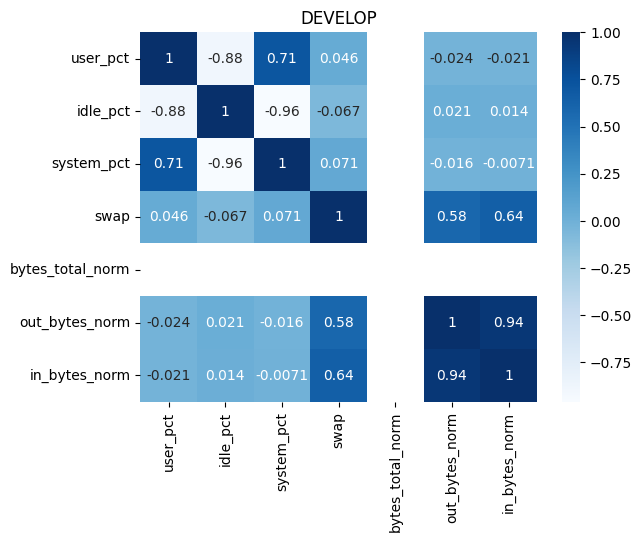

In [3]:
correlation(servers[0])

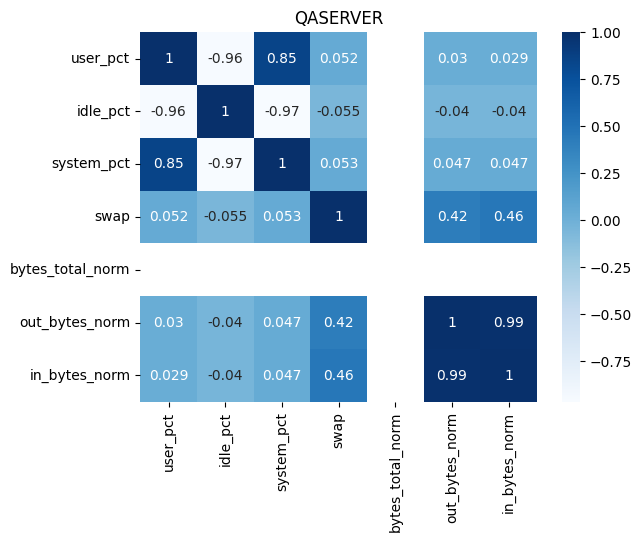

In [4]:
correlation(servers[1])

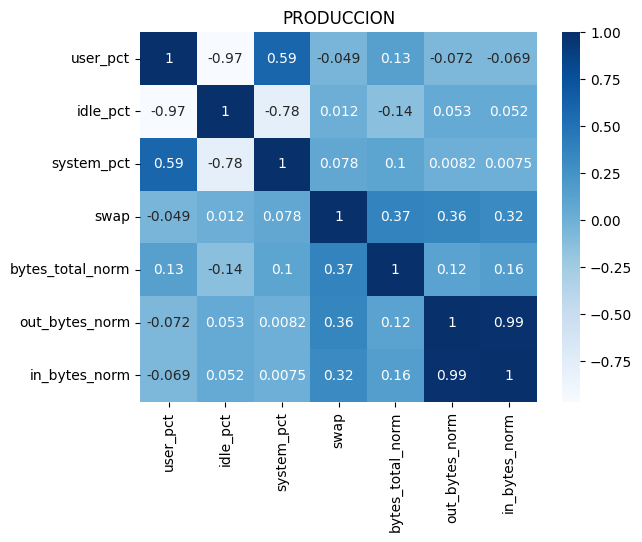

In [5]:
correlation(servers[2])

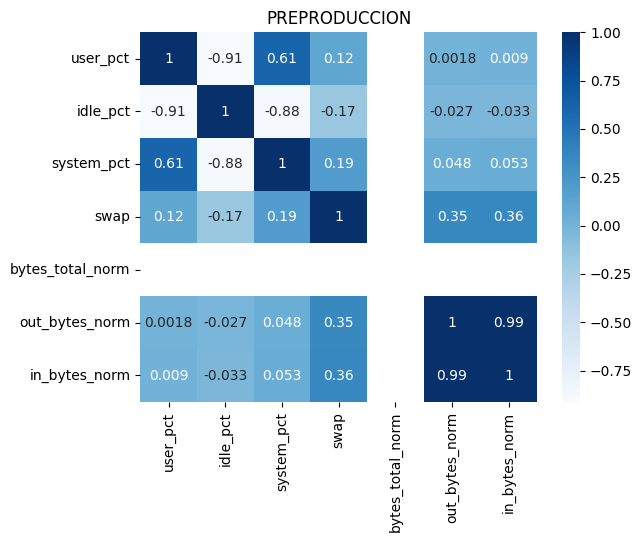

In [6]:
correlation(servers[3])

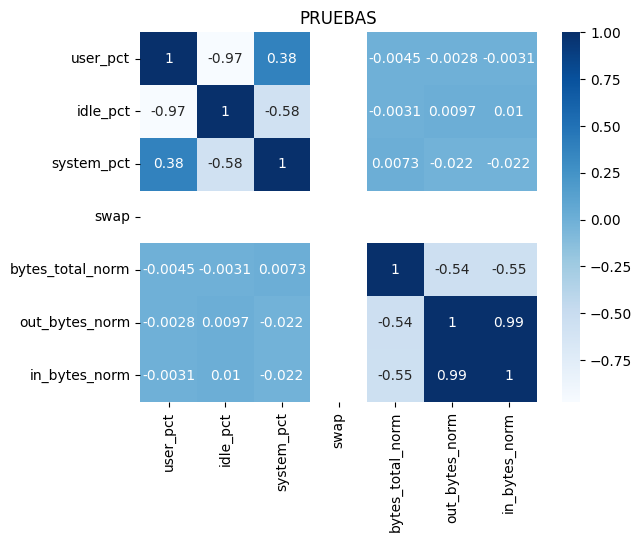

In [7]:
correlation(servers[4])

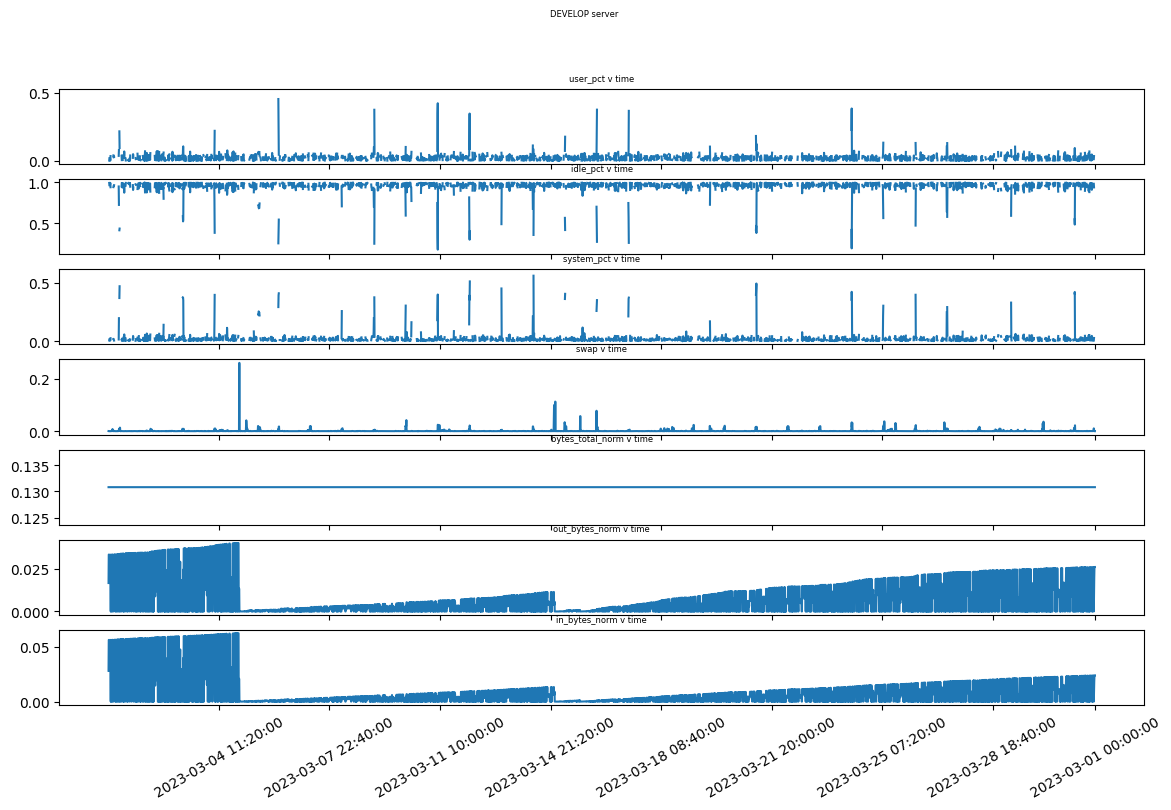

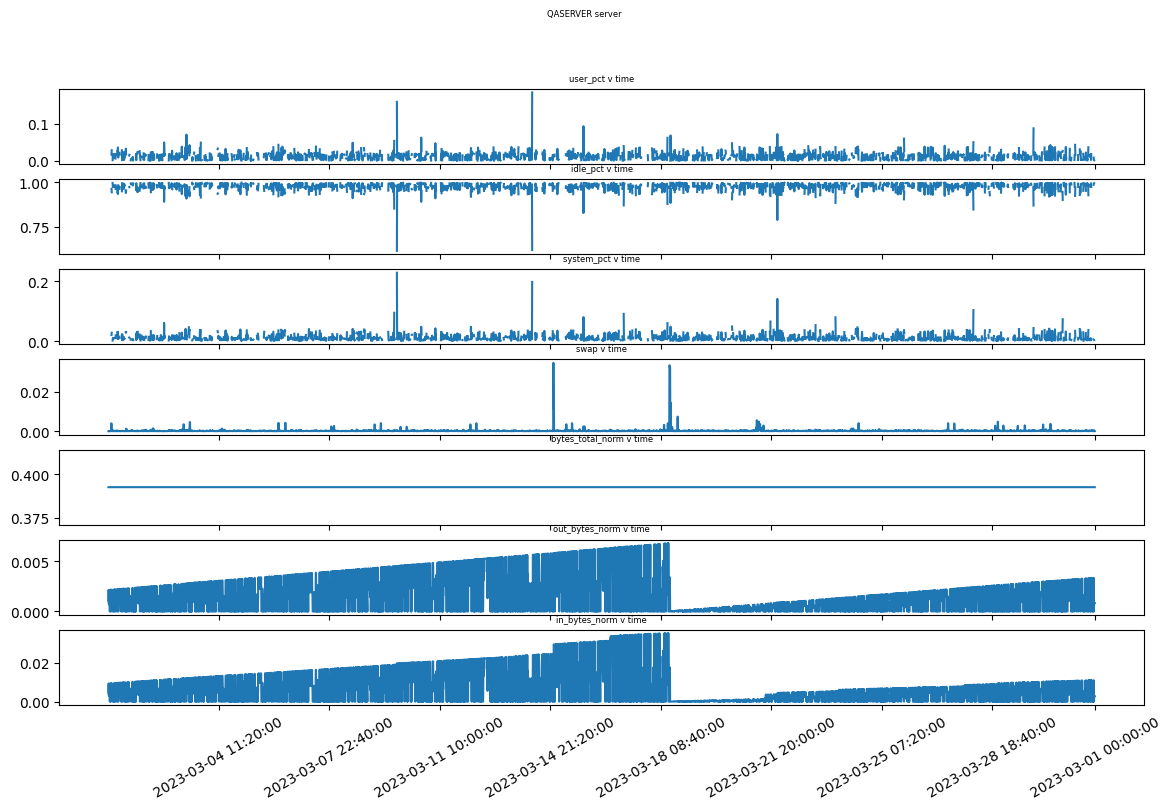

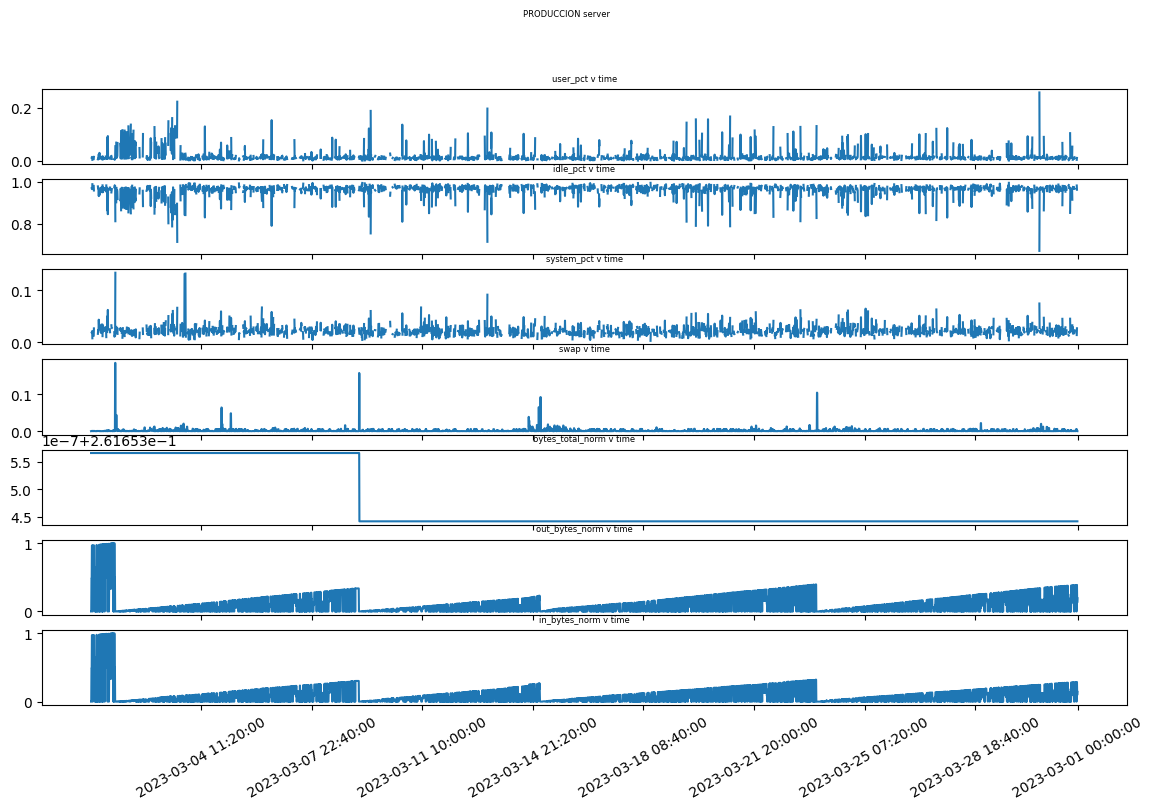

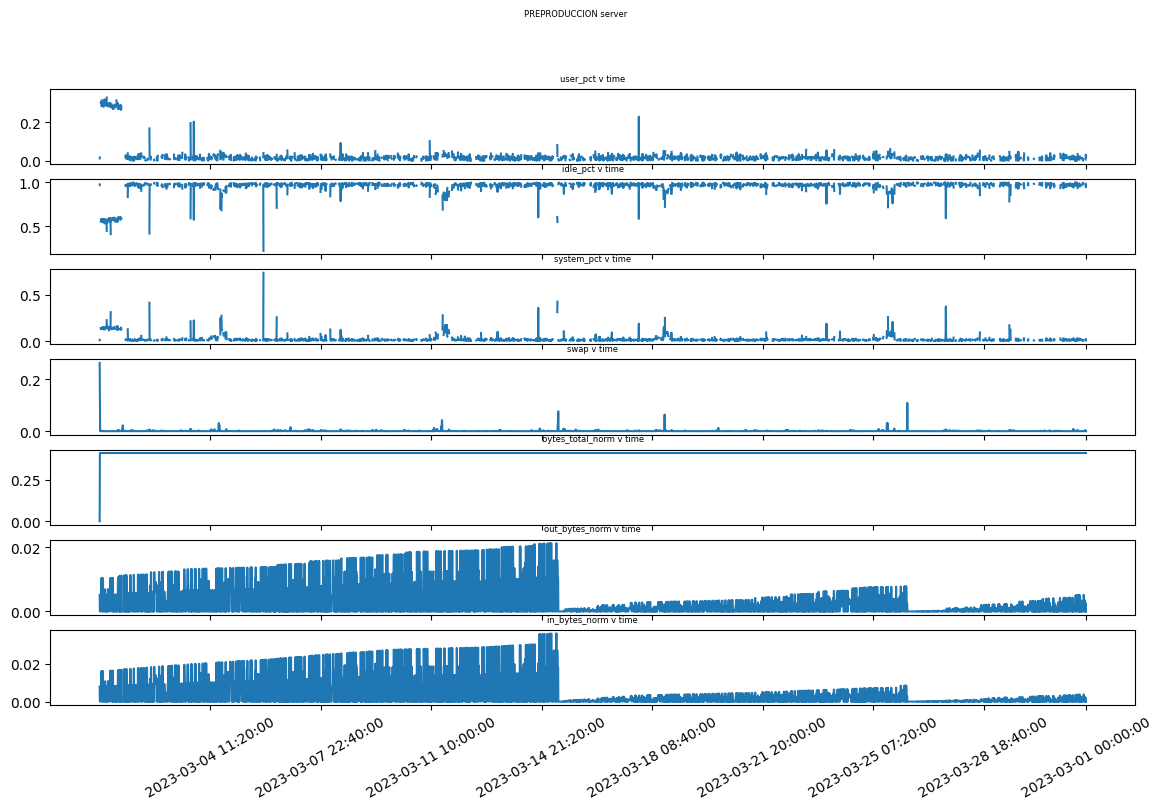

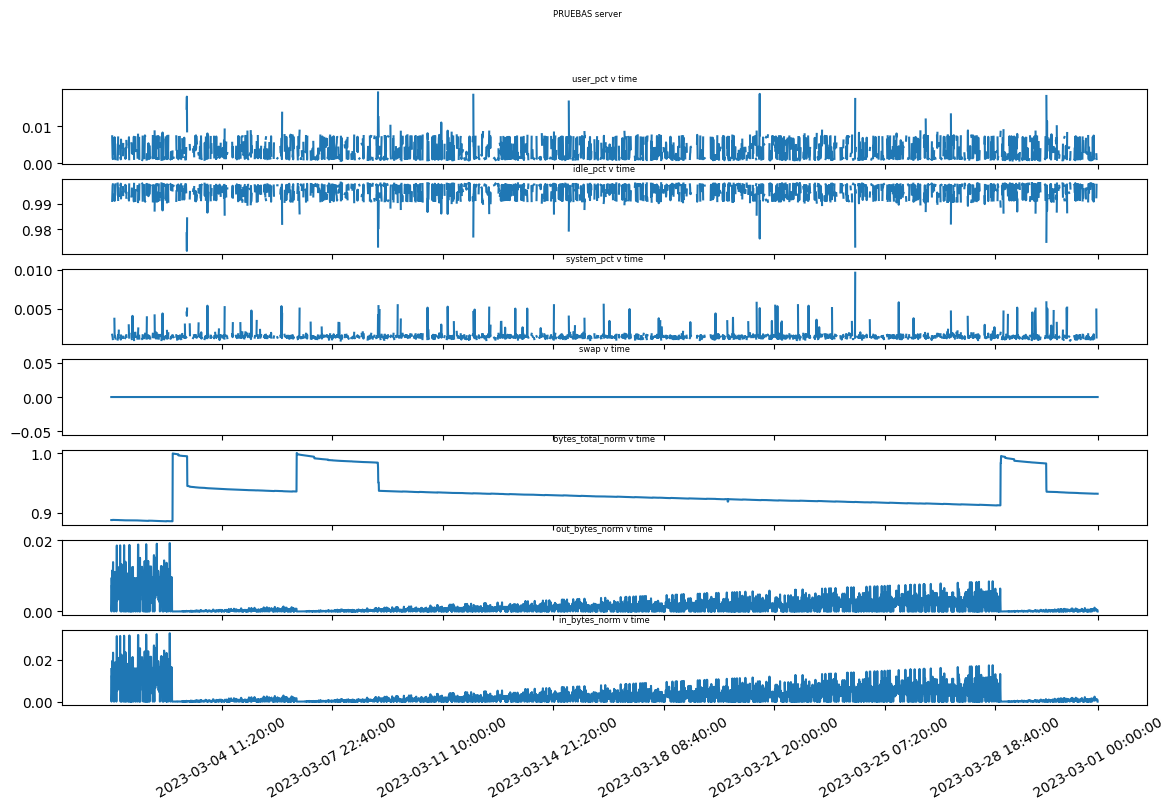

In [10]:
def plot(name):

    data = pd.read_csv("resampled/" + name + "_resampled.csv")
    data = data.drop(["swap_norm","bytes_total","out_bytes","in_bytes","actual_used_bytes","free","actual_used_pct","swap_free"],axis=1)

    time = data["@timestamp"]
    time = time[1:]
    time_tick = data["@timestamp"][::500]

    user_pct = data["user_pct"]
    idle_pct = data["idle_pct"]
    system_pct = data["system_pct"]
    swap = data["swap"]
    bytes_total_norm = data["bytes_total_norm"]
    out_bytes_norm = data["out_bytes_norm"]
    in_bytes_norm = data["in_bytes_norm"]
    
    N_bytes_total_norm = np.zeros((len(out_bytes_norm),1))
    N_out_bytes = np.zeros((len(out_bytes_norm),1))
    N_in_bytes = np.zeros((len(out_bytes_norm),1))
    N_swap = np.zeros((len(out_bytes_norm),1))

    for i in range(len(out_bytes_norm)):
        if (np.isnan(out_bytes_norm[i])==True):
            if i == 0:
                N_out_bytes[i] = 0
            else:
                N_out_bytes[i] = N_out_bytes[i-1]
        else:
            N_out_bytes[i] = out_bytes_norm[i]
        if (np.isnan(in_bytes_norm[i])==True):
            if i == 0:
                N_in_bytes[i] = in_bytes_norm[i+1]
            else:
                N_in_bytes[i] = N_in_bytes[i-1]
        else:
            N_in_bytes[i] = in_bytes_norm[i]
        if (np.isnan(swap[i])==True):
            if i == 0:
                N_swap[i] = 0
            else:
                N_swap[i] = N_swap[i-1]
        else:
            N_swap[i] = swap[i]
        if (np.isnan(bytes_total_norm[i])==True):
            if i == 0:
                N_bytes_total_norm[i] = 0
            else:
                N_bytes_total_norm[i] = N_bytes_total_norm[i-1]
        else:
            N_bytes_total_norm[i] = bytes_total_norm[i]


    grad_swap = np.abs(np.gradient(N_swap[1:].flatten()))

    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7,sharex=True,figsize=(14,8))
    fig.suptitle(name + " server",fontsize = 6)

    ax1.plot(time, user_pct[1:])
    ax1.set_title("user_pct v time",fontsize = 6)

    ax2.plot(time, idle_pct[1:])
    ax2.set_title("idle_pct v time",fontsize = 6)

    ax3.plot(time, system_pct[1:])
    ax3.set_title("system_pct v time",fontsize = 6)

    ax4.plot(time, grad_swap)
    ax4.set_title("swap v time",fontsize = 6)

    ax5.plot(time, N_bytes_total_norm[1:])
    ax5.set_title("bytes_total_norm v time",fontsize = 6)

    ax6.plot(time, N_out_bytes[1:])
    ax6.set_title("out_bytes_norm v time",fontsize = 6)

    ax7.plot(time, N_in_bytes[1:])
    ax7.set_title("in_bytes_norm v time",fontsize = 6)

    plt.xticks(rotation=30)
    plt.xticks(time_tick)
    plt.show()
    return "cum"

def start():
    servers = ['DEVELOP','QASERVER','PRODUCCION', 'PREPRODUCCION','PRUEBAS']
    for i in range(5):
        plot(servers[i])

start()